In [1]:
!nvidia-smi

Tue Nov 30 17:59:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.86       Driver Version: 470.86       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:09:00.0  On |                  N/A |
| 36%   59C    P8    36W / 350W |   2118MiB / 24259MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# !pip install -q -U watermark
# !pip install -qq transformers
# %reload_ext watermark
# %watermark -v -p numpy,pandas,torch,transformers

In [3]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, AutoTokenizer, AutoModelForSequenceClassification
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import f1_score

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# New Section

In [4]:
from transformers import BertTokenizer,BertModel
# PRE_TRAINED_MODEL_NAME = "hfl/chinese-roberta-wwm-ext"
# PRE_TRAINED_MODEL_NAME = "hfl/chinese-roberta-wwm-ext-large"
# PRE_TRAINED_MODEL_NAME = "hfl/chinese-bert-wwm-ext"
PRE_TRAINED_MODEL_NAME = "bert-base-uncased"
# PRE_TRAINED_MODEL_NAME = "ProsusAI/finbert"
# PRE_TRAINED_MODEL_NAME = "bert-base-chinese"
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME,do_lower_case=True)

In [5]:
data1 = pd.read_csv('./data/Twitter_Data.csv')

In [6]:
data1 = data1.rename(columns={'clean_text':'text','category':"rating"})

In [7]:
data1 = data1.loc[~data1.rating.isna()]

In [8]:
df_train = pd.read_csv('./data/train.csv',sep='\t')
df_test = pd.read_csv('./data/test.csv',sep='\t')

In [9]:


# config = BertConfig.from_json_file('/content/drive/MyDrive/model/chinese_wwm_pytorch/bert_config.json')


In [10]:
# data = pd.read_csv('/content/drive/MyDrive/project/data/generatedBy_react-csv (45).csv')
# data = data.sample(frac=1)
# data = data.reset_index(drop=True)


# df_train = data.loc[:int(len(data)*0.6)]
# df_train.to_csv('/content/drive/MyDrive/project/data/train.csv',sep='\t',index=None)
# df_test = data.loc[int(len(data)*0.6):]
# df_test.to_csv('/content/drive/MyDrive/project/data/test.csv',sep='\t',index=None)

In [11]:
df_train = df_train[['text','rating']]
df_test = df_test[['text','rating']]

In [12]:
# data1 = pd.concat([df_train,data1])
data1 = data1.reset_index(drop=True)
data1.rating = data1.rating.astype('int')
data1 = data1.sample(frac=0.1)
data1 = data1.reset_index(drop=True)

In [13]:
len(data1)*0.9

14667.300000000001

In [14]:
df_train = data1.loc[:int(len(data1)*0.9)]

In [15]:
df_val = data1.loc[int(len(data1)*0.9):]

In [16]:
df_train

,text,rating
0,cant work like modi yogi next,0
1,remember she was the 1st bjp who ignored modis...,0
2,not lier like jumlebaz fulfill what committed ...,0
3,for all champions free economy this real raghu...,1
4,delhi prime minister narendra modi speaking bj...,1
...,...,...
14663,wait milan supporting ubi next time you say mo...,1
14664,have filed our detailed response the showcause...,1
14665,happy bday deshbhakt\nyour arms looks amazing\...,1
14666,and the narrative shifted out modis hands with...,1


In [17]:
# data.text = data.text.str.replace('[newLine]','')
# data.text = data.text.str.replace('[doubleQuote]','\"')

In [18]:
df_train.rating = df_train.rating+1
df_test.rating = df_test.rating+1
df_val.rating = df_val.rating+1

/home/bit/anaconda3/envs/py38/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [19]:
df_train,df_test,df_val

(                                                    text  rating
 0                          cant work like modi yogi next       1
 1      remember she was the 1st bjp who ignored modis...       1
 2      not lier like jumlebaz fulfill what committed ...       1
 3      for all champions free economy this real raghu...       2
 4      delhi prime minister narendra modi speaking bj...       2
 ...                                                  ...     ...
 14663  wait milan supporting ubi next time you say mo...       2
 14664  have filed our detailed response the showcause...       2
 14665  happy bday deshbhakt\nyour arms looks amazing\...       2
 14666  and the narrative shifted out modis hands with...       2
 14667  revanna said 420 officer rediculed officer mod...       2
 
 [14668 rows x 2 columns],
                                                   text  rating
 0    @✱✱✱ promised big news re. biomarker testing &...       2
 1    How can we maximise the potential of precisio

/home/bit/anaconda3/envs/py38/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


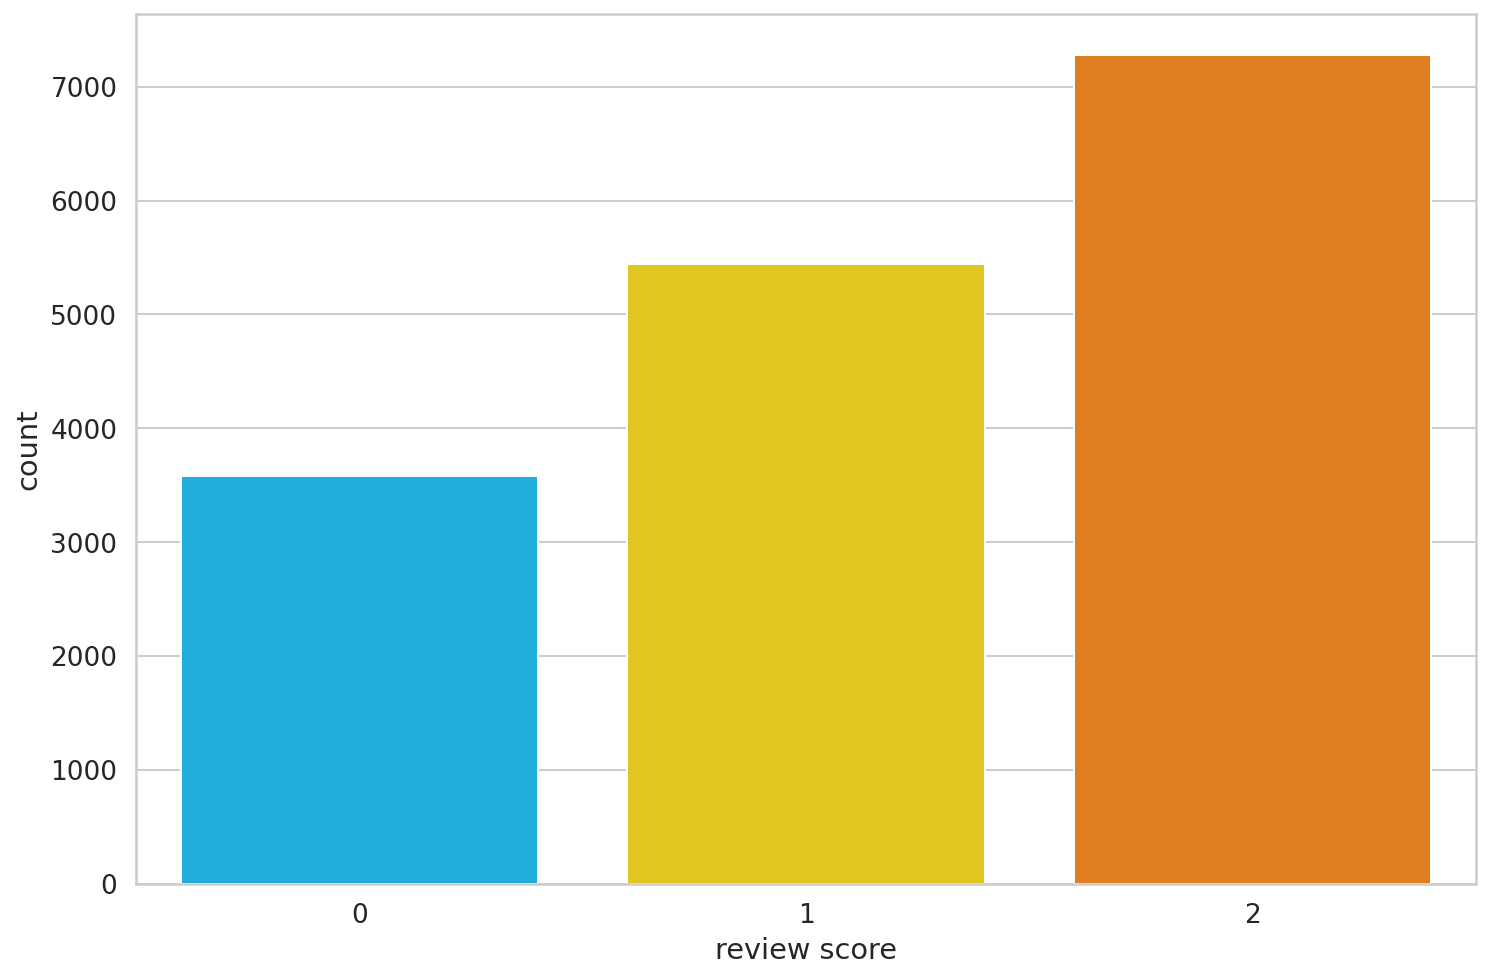

In [20]:
sns.countplot(data1.rating)
plt.xlabel('review score');

In [21]:
# df_train = data.loc[0:0.6*len(data)]
# df_val = data.loc[0.6*len(data):0.8*len(data)]
# df_test = data.loc[0.8*len(data):]

In [22]:
# tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME,do_lower_case=True, tokenize_chinese_chars=True)

In [23]:
# train = pd.read_csv('/content/drive/MyDrive/data/chnsenticorp/train.tsv',sep='\t')
# test = pd.read_csv('/content/drive/MyDrive/data/chnsenticorp/test.tsv',sep='\t')
# dev = pd.read_csv('/content/drive/MyDrive/data/chnsenticorp/dev.tsv',sep='\t')

In [24]:
# train = train.rename(columns = {'label':"LABEL",'text_a':'news'})
# test = test.rename(columns = {'label':"LABEL",'text_a':'news'})
# dev = dev.rename(columns = {'label':"LABEL",'text_a':'news'})

In [25]:
# df = train

In [26]:
# df.loc[df.DESCRIPTION.apply(len)>300].head(5)

In [27]:
# sample_txt = df.loc[12085,"DESCRIPTION"]

In [28]:
# len(sample_txt)

In [29]:
# sample_txt.loc[3406]['DESCRIPTION_EN']

In [30]:
sample_txt = 'Rambler expects net profit in the first quarter to increase by 70% - 80% year on year'

In [31]:
# sample_txt = sample_txt
# tokens = tokenizer.tokenize(sample_txt)
# token_ids = tokenizer.convert_tokens_to_ids(tokens)

# print(f' Sentence: {sample_txt}')
# print(f'   Tokens: {tokens}')
# print(f'Token IDs: {token_ids}')

In [32]:
# sentences = df["DESCRIPTION"].values

In [33]:
# sentence = sample_txt.split(' ')

In [34]:
# sentence.insert(1,'')
# sentence.insert(13,'')
# sentence.insert(16,'')

In [35]:
# s = pd.DataFrame([sentence,tokens,token_ids])
# # s = s.rename(columns={0:"Tokens",1: "Token IDs"})
# s[20] = pd.Series(["Sentence:","Token:",'Token IDs:'])

In [36]:
# s = s.set_index([20])


In [37]:
# s.style.set_properties(**{'text-align': 'left'})
# s

In [38]:
# max_len = 0

# # For every sentence...
# for sent in sentences:

#     # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
#     input_ids = tokenizer.encode(sent, add_special_tokens=True)

#     # Update the maximum sentence length.
#     max_len = max(max_len, len(input_ids))

# print('Max sentence length: ', max_len)

In [39]:
max_len=300

In [40]:
# a = np.array([*map(len,sentences)])
# np.where(a > 300)

In [41]:
# encoding = tokenizer.encode_plus(
#   sample_txt,
#   max_length=max_len,
#   add_special_tokens=True, # Add '[CLS]' and '[SEP]'
#   return_token_type_ids=False,
#   pad_to_max_length=True,
#   padding='max_length',
#   truncation=True,
#   return_attention_mask=True,
#   return_tensors='pt',  # Return PyTorch tensors
# )

# # encoding.keys()

In [42]:
# print(len(encoding['input_ids'][0]))
# encoding['input_ids'][0]

In [43]:
# print(len(encoding['attention_mask'][0]))
# encoding['attention_mask']

In [44]:
# tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

In [45]:
# token_lens = []

# for txt in df.DESCRIPTION:
#   tokens = tokenizer.encode(txt, max_length=300)
#   token_lens.append(len(tokens))

In [46]:
max_len = 300

In [47]:
class_names = ['negative','neutral', 'positive']

In [48]:
# sns.distplot(token_lens)
# plt.xlabel('Token count')

In [49]:
# MAX_LEN = 300
# from torch.utils.data import Dataset

In [50]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [51]:
# name = "CHANGE"
# path = '/content/drive/MyDrive/data/df_'
# df_train = pd.read_csv(path+"train_srl.csv",sep='\t',index_col=None)
# df_test = pd.read_csv(path+"test_srl.csv",sep='\t',index_col=None)
# df_val = pd.read_csv(path+"val_srl.csv",sep='\t',index_col=None)

In [52]:
# sns.countplot(pd.concat([df_train,df_test,df_val]).label)
# plt.xlabel('review score');

In [53]:
df_train.shape, df_val.shape, df_test.shape

((14668, 2), (1630, 2), (126, 2))

In [54]:
# # df_train, df_test,df_val = train, test,dev
# tem_train = df_train[["DATE","DESCRIPTION_EN_ZH","LABEL"]]
# tem_train1 = df_train[["DATE","DESCRIPTION","LABEL"]]
# # df_train = pd.concat([df_train[]

In [55]:
# 

In [56]:
# tem_train = tem_train.rename(columns={"DESCRIPTION_EN_ZH":"DESCRIPTION"})

In [57]:
# df_train = pd.concat([tem_train1,tem_train])

In [58]:
# df_train = df_train.sort_values("DATE")

In [59]:
# df_train.shape, df_val.shape, df_test.shape

In [60]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.text.to_numpy(),
    targets=df.rating.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [61]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, max_len, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, max_len, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, max_len, BATCH_SIZE)

In [62]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    # self.drop = nn.Dropout(p=0.1)
    # self.relu = nn.ReLU()
    # self.L1 = nn.Linear(self.bert.config.hidden_size,self.bert.config.hidden_size//2)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )[1]
    
    # output = self.drop(pooled_output)
    # # output = self.L1(output)
    output = self.out(pooled_output)
 
    return output

In [63]:
model = SentimentClassifier(3)
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [64]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [65]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [66]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [67]:
history = defaultdict(list)
best_accuracy = 0
# EPOCHS = 5

In [68]:
%%time

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc
  torch.save(model.state_dict(), 'last_model_state.bin')

Epoch 1/10
----------
Train loss 0.507582180839816 accuracy 0.8008590128170167
Val   loss 0.31197533225092816 accuracy 0.9055214723926381

Epoch 2/10
----------
Train loss 0.22313180373831284 accuracy 0.9393918734660485
Val   loss 0.28575044368649377 accuracy 0.9239263803680983

Epoch 3/10
----------
Train loss 0.14604007274954964 accuracy 0.9657076629397328
Val   loss 0.3822618099340402 accuracy 0.9196319018404908

Epoch 4/10
----------
Train loss 0.09474048902215375 accuracy 0.9784565039541859
Val   loss 0.3756094520144603 accuracy 0.9196319018404908

Epoch 5/10
----------
Train loss 0.06640866709470133 accuracy 0.9854104172347968
Val   loss 0.420106501037748 accuracy 0.9233128834355829

Epoch 6/10
----------
Train loss 0.0468794084782801 accuracy 0.98970548131988
Val   loss 0.41985086874646027 accuracy 0.9288343558282209

Epoch 7/10
----------
Train loss 0.03011793594646728 accuracy 0.9928415598581947
Val   loss 0.4213148914092088 accuracy 0.9337423312883436

Epoch 8/10
----------


KeyboardInterrupt: 

In [73]:
len(history["train_acc"])

7

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

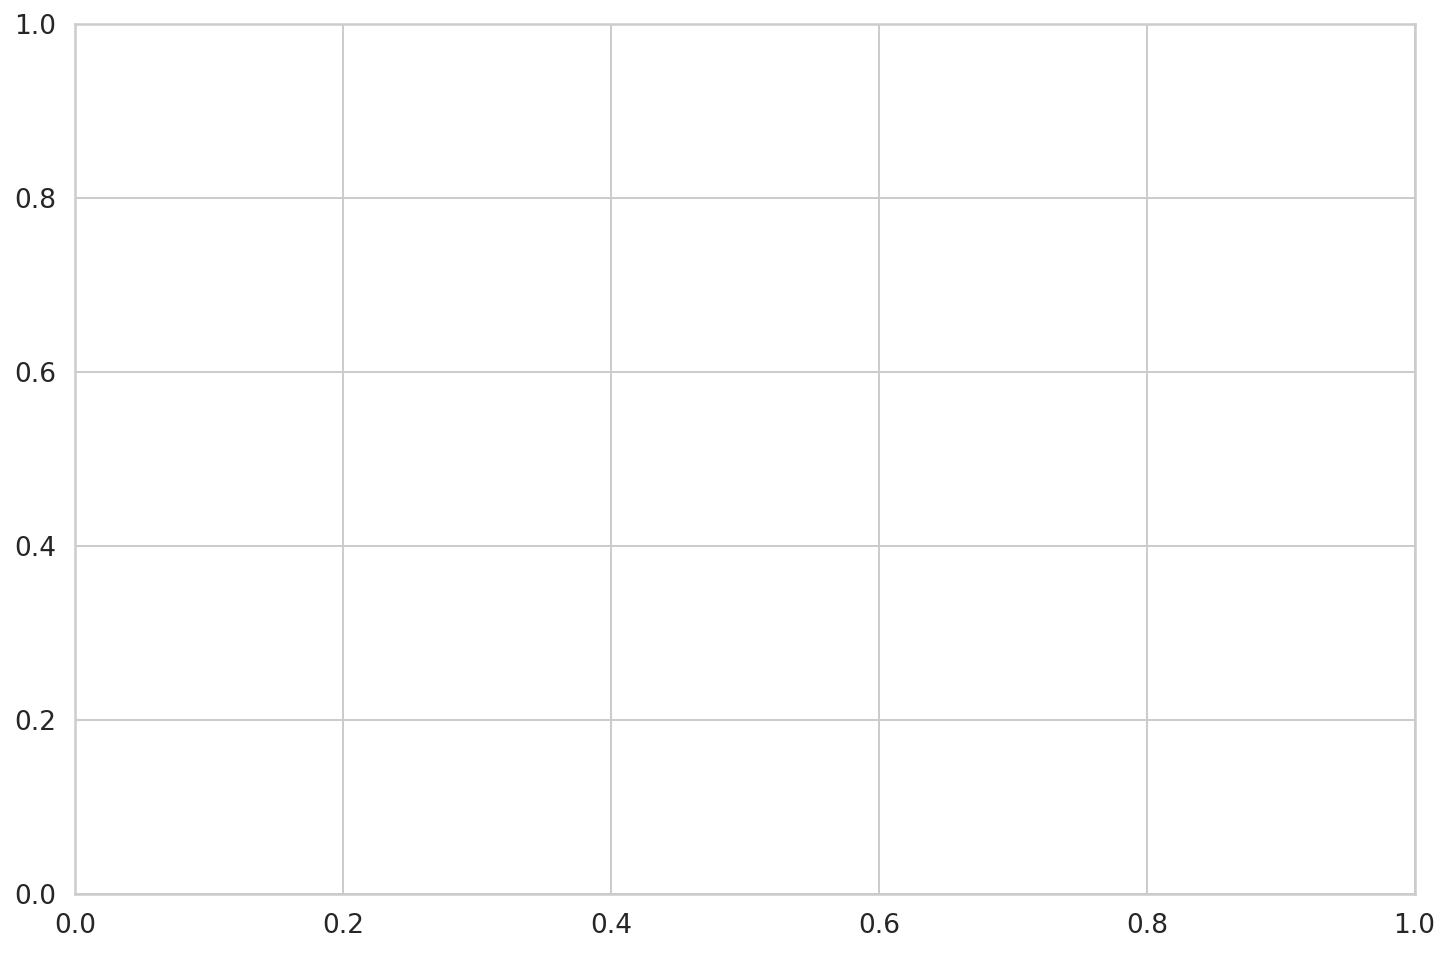

In [74]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
# tokenizer.save_vocabulary('vacab.txt')

In [ ]:
# tokenizer.save_pretrained('content/drive/MyDrive/model/best_model/')

In [ ]:
# model.bert.save_pretrained('best_model_state.bin')

In [75]:
# !gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA

model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [76]:
len(df_test)

126

In [77]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.5317460317460317

In [78]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [79]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [80]:
print(classification_report(y_test, y_pred, target_names=class_names,digits = 4))

              precision    recall  f1-score   support

    negative     0.1667    0.0526    0.0800        19
     neutral     0.4400    0.2895    0.3492        38
    positive     0.5789    0.7971    0.6707        69

    accuracy                         0.5317       126
   macro avg     0.3952    0.3797    0.3666       126
weighted avg     0.4749    0.5317    0.4847       126



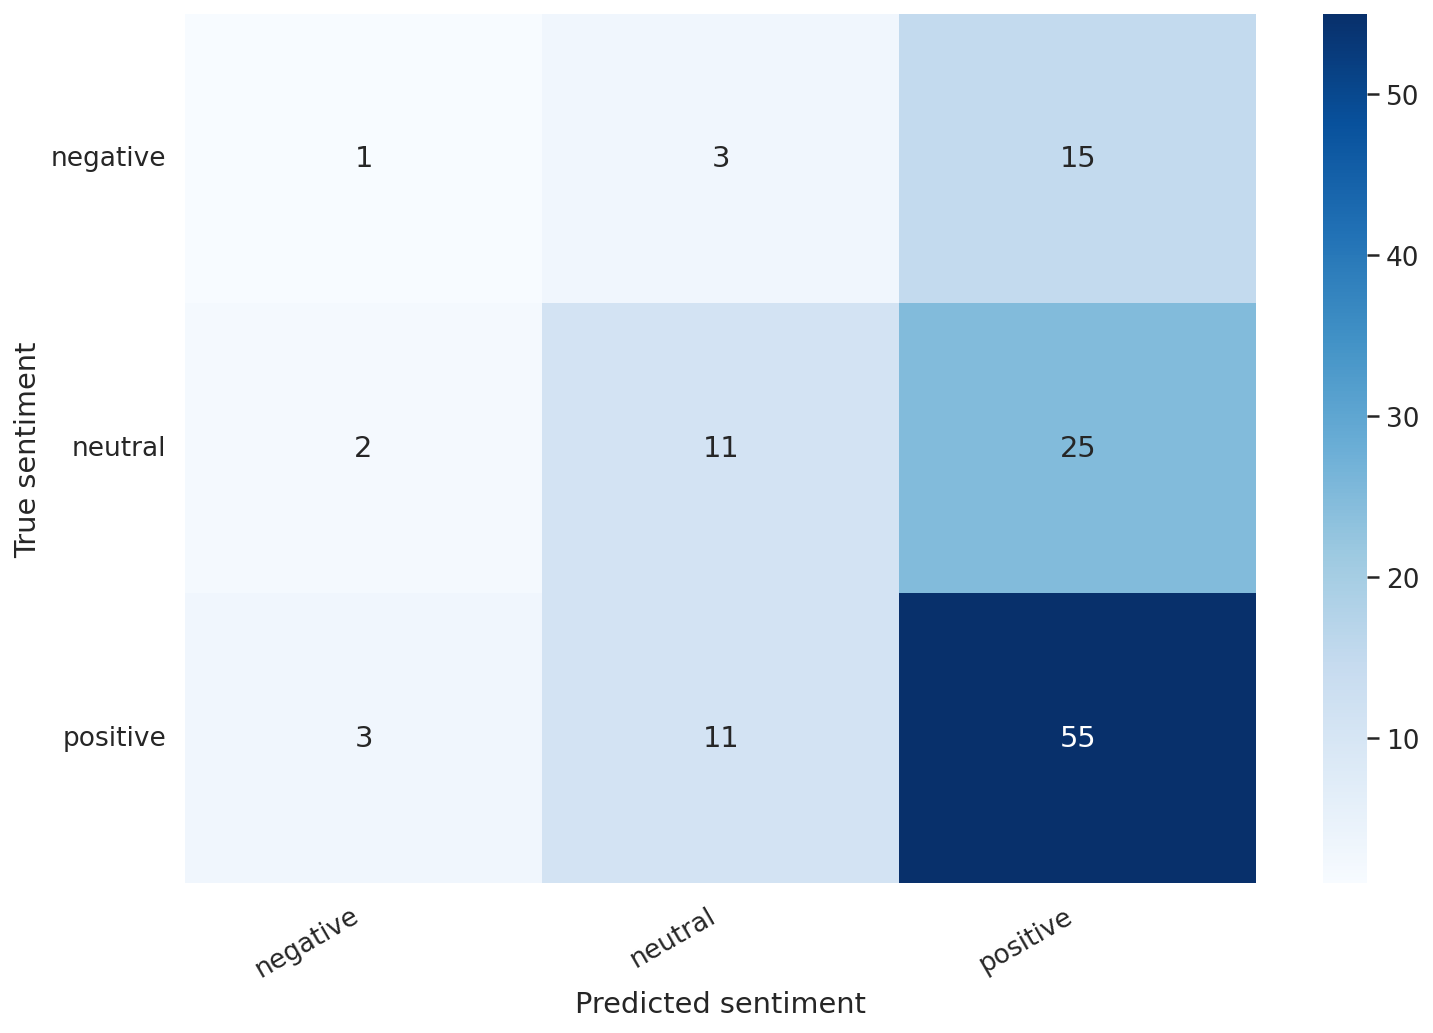

In [81]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
# !pip install lit-nlp

In [ ]:
# from lit_nlp.api.dataset import Dataset
# class MultiNLIData(Dataset):
#   """Loader for MultiNLI development set."""
#   def __init__(self, df):
#     # Read the eval set from a .tsv file as distributed with the GLUE benchmark.
#     # df = pandas.read_csv(path, sep='\t')
#     # Store as a list of dicts, conforming to self.spec()
#     self.LABELS = [0,1]
#     self._examples = [{
#       'sentence': row['DESCRIPTION_EN'],
#       # 'hypothesis': row['sentence2'],
#       'label': row['LABEL']
#       # 'genre': row['genre'],
#     } for _, row in df.iterrows()]
#   def spec(self):
#     return {
#       'sentence': lit_types.TextSegment(),
#       # 'hypothesis': lit_types.TextSegment(),
#       'label': lit_types.CategoryLabel(vocab=self.LABELS),
#       # We can include additional fields, which don't have to be used by the model.
#       # 'genre': lit_types.Label(),
#     }

In [ ]:
# from absl import app
# from absl import flags
# from absl import logging

# from lit_nlp import dev_server
# from lit_nlp import server_flags
# from lit_nlp.api import model as lit_model
# from lit_nlp.api import types as lit_types
# # Use the regular GLUE data loaders, because these are very simple already.
# from lit_nlp.examples.datasets import glue
# from lit_nlp.lib import utils

# import torch
# import transformers

# # NOTE: additional flags defined in server_flags.py

# FLAGS = flags.FLAGS

# flags.DEFINE_string(
#     "model_path",
#     "https://storage.googleapis.com/what-if-tool-resources/lit-models/sst2_tiny.tar.gz",
#     "Path to trained model, in standard transformers format, e.g. as "
#     "saved by model.save_pretrained() and tokenizer.save_pretrained()")


# def _from_pretrained(cls, *args, **kw):
#   """Load a transformers model in PyTorch, with fallback to TF2/Keras weights."""
#   try:
#     return cls.from_pretrained(*args, **kw)
#   except OSError as e:
#     logging.warning("Caught OSError loading model: %s", e)
#     logging.warning(
#         "Re-trying to convert from TensorFlow checkpoint (from_tf=True)")
#     return cls.from_pretrained(*args, from_tf=True, **kw)


# class SimpleSentimentModel(lit_model.Model):
#   """Simple sentiment analysis model."""

#   LABELS = [0,1]  # negative, positive

#   def __init__(self, model_name_or_path):
#     self.tokenizer = transformers.AutoTokenizer.from_pretrained(
#         model_name_or_path)
#     model_config = transformers.AutoConfig.from_pretrained(
#         model_name_or_path,
#         num_labels=2,
#         output_hidden_states=True,
#         output_attentions=True,
#     )
#     # This is a just a regular PyTorch model.
#     self.model = _from_pretrained(
#         transformers.AutoModelForSequenceClassification,
#         model_name_or_path,
#         config=model_config)
#     self.model.eval()

#   ##
#   # LIT API implementation
#   def max_minibatch_size(self):
#     # This tells lit_model.Model.predict() how to batch inputs to
#     # predict_minibatch().
#     # Alternately, you can just override predict() and handle batching yourself.
#     return 16

#   def predict_minibatch(self, inputs):
#     # Preprocess to ids and masks, and make the input batch.
#     encoded_input = self.tokenizer.batch_encode_plus(
#         [ex["sentence"] for ex in inputs],
#         return_tensors="pt",
#         add_special_tokens=True,
#         max_length=200,
#         padding="longest",
#         truncation="longest_first")

#     # Check and send to cuda (GPU) if available
#     if torch.cuda.is_available():
#       self.model.cuda()
#       for tensor in encoded_input:
#         encoded_input[tensor] = encoded_input[tensor].cuda()
#     # Run a forward pass.
#     with torch.no_grad():  # remove this if you need gradients.
#       out: transformers.modeling_outputs.SequenceClassifierOutput = \
#           self.model(**encoded_input)

#     # Post-process outputs.
#     batched_outputs = {
#         "probas": torch.nn.functional.softmax(out.logits, dim=-1),
#         "input_ids": encoded_input["input_ids"],
#         "ntok": torch.sum(encoded_input["attention_mask"], dim=1),
#         "cls_emb": out.hidden_states[-1][:, 0],  # last layer, first token
#     }
#     # Return as NumPy for further processing.
#     detached_outputs = {k: v.cpu().numpy() for k, v in batched_outputs.items()}
#     # Unbatch outputs so we get one record per input example.
#     for output in utils.unbatch_preds(detached_outputs):
#       ntok = output.pop("ntok")
#       output["tokens"] = self.tokenizer.convert_ids_to_tokens(
#           output.pop("input_ids")[1:ntok - 1])
#       yield output

#   def input_spec(self) -> lit_types.Spec:
#     return {
#         "sentence": lit_types.TextSegment(),
#         "label": lit_types.CategoryLabel(vocab=self.LABELS, required=False)
#     }

#   def output_spec(self) -> lit_types.Spec:
#     return {
#         "tokens": lit_types.Tokens(),
#         "probas": lit_types.MulticlassPreds(parent="label", vocab=self.LABELS),
#         "cls_emb": lit_types.Embeddings()
#     }


In [ ]:
# dataset = MultiNLIData(df_train.sample(1800))

In [ ]:
# datasets = {"sst_dev": dataset}
# models = {"sst": SimpleSentimentModel("/content/drive/MyDrive/model/best_model/")}
# # models = {"sst": SimpleSentimentModel("bert-base-uncased")}

In [ ]:
# from lit_nlp import notebook
# widget = notebook.LitWidget(models, datasets, height=800)

In [ ]:
# mm = models["sst"]

In [ ]:
# mm.model.config

In [ ]:
# widget.render()

In [ ]:
# dataset.LABELS


In [ ]:
# df.loc[df.NAME=="三角防务"]